In [1]:
import cv2
import imutils
import numpy as np
import pytesseract as tess
from matplotlib import pyplot as plt

In [2]:
pwd

'/Users/indra25/Desktop/DIA/analysis'

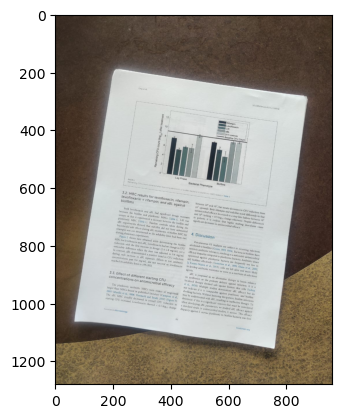

In [3]:
img = cv2.imread("./../samples/img.jpeg")
img = cv2.resize(img, (int(480*2), int(640*2)))
plt.imshow(img[:,:,::-1])

<BarContainer object of 256 artists>

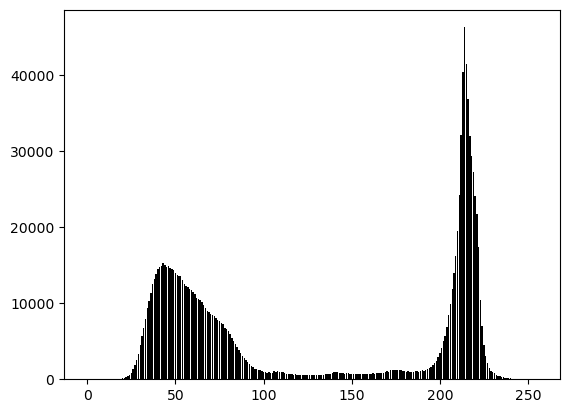

In [4]:
intensity_hist1 = cv2.calcHist([img], [0], None, [256], [0, 255])
intensity_hist1 = np.reshape(intensity_hist1,(intensity_hist1.shape[0]))
plt.bar(range(256),intensity_hist1,color='black')

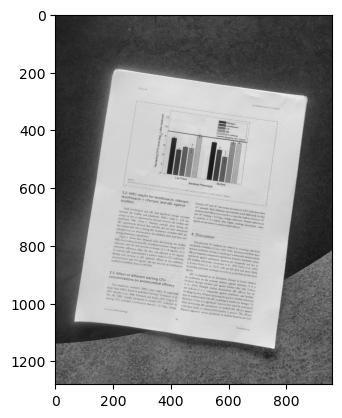

In [5]:
GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(GrayImg, cmap='gray')

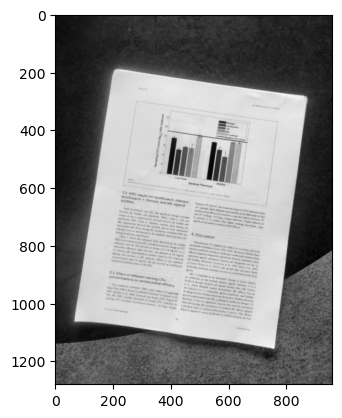

In [6]:
BlurredFrame = cv2.GaussianBlur(GrayImg, (5, 5), 1)
plt.imshow(BlurredFrame, cmap='gray')

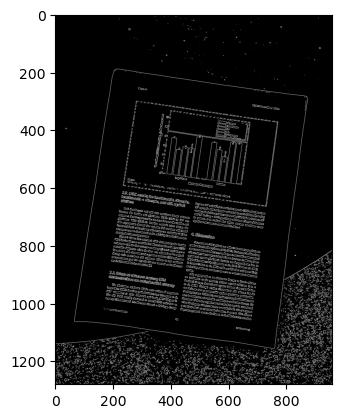

In [7]:
CannyFrame = cv2.Canny(BlurredFrame, 70, 70)
plt.imshow(CannyFrame, cmap='gray')

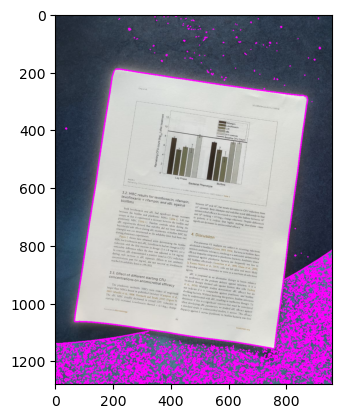

In [8]:
contours, _ = cv2.findContours(CannyFrame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ContourFrame = img.copy()
ContourFrame = cv2.drawContours(ContourFrame, contours, -1, (255, 0, 255), 4)
plt.imshow(ContourFrame)

In [10]:
def drawRec(biggestNew, mainFrame):
        cv2.line(mainFrame, (biggestNew[0][0][0], biggestNew[0][0][1]), (biggestNew[1][0][0], biggestNew[1][0][1]), (0, 255, 0), 20)
        cv2.line(mainFrame, (biggestNew[0][0][0], biggestNew[0][0][1]), (biggestNew[2][0][0], biggestNew[2][0][1]), (0, 255, 0), 20)
        cv2.line(mainFrame, (biggestNew[3][0][0], biggestNew[3][0][1]), (biggestNew[2][0][0], biggestNew[2][0][1]), (0, 255, 0), 20)
        cv2.line(mainFrame, (biggestNew[3][0][0], biggestNew[3][0][1]), (biggestNew[1][0][0], biggestNew[1][0][1]), (0, 255, 0), 20)

#initializing
img = cv2.imread("./../samples/img.jpeg")
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.resize(img, (int(480*2), int(640*2)))
w, h = 480, 640
imgWarp = img.copy()

# detect frame
GrayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
BlurredFrame = cv2.GaussianBlur(GrayImg, (5, 5), 1)
CannyFrame = cv2.Canny(BlurredFrame, 190, 190)
contours, _ = cv2.findContours(CannyFrame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ContourFrame = img.copy()
ContourFrame = cv2.drawContours(ContourFrame, contours, -1, (255, 0, 255), 4)

CornerFrame = img.copy()
maxArea = 0
max_area = 0
biggest = []
for i in contours :
    area = cv2.contourArea(i)
    max_area = max(max_area,area)    
    if area > 10 :
        peri = cv2.arcLength(i, True)
        edges = cv2.approxPolyDP(i, 0.02*peri, True)
        print(peri,len(edges))
        if area > maxArea and len(edges) == 4 :
            biggest = edges
            maxArea = area
print(max_area)
if len(biggest) != 0 :
   # drawRec(biggest, CornerFrame)
    biggest = biggest.reshape((4, 2))
    biggestNew = np.zeros((4, 1, 2), dtype= np.int32)
    add = biggest.sum(1)
    biggestNew[0] = biggest[np.argmin(add)]
    biggestNew[3] = biggest[np.argmax(add)]
    dif = np.diff(biggest, axis = 1)
    biggestNew[1] = biggest[np.argmin(dif)]
    biggestNew[2] = biggest[np.argmax(dif)]
    drawRec(biggestNew, CornerFrame)
    print(biggestNew)
    CornerFrame = cv2.drawContours(CornerFrame, biggestNew, -1, (255, 0, 255), 25)
    pts1 = np.float32(biggestNew)
    pts2 = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    imgWarp = cv2.warpPerspective(img, matrix, (w, h))


412.49956130981445 2
3280.638733148575 4
602458.5
[[[ 210  190]]

 [[ 870  286]]

 [[  67 1063]]

 [[ 756 1157]]]


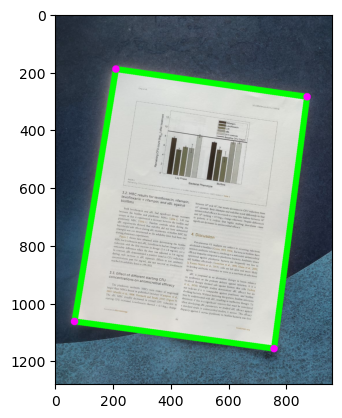

In [11]:
plt.imshow(CornerFrame)

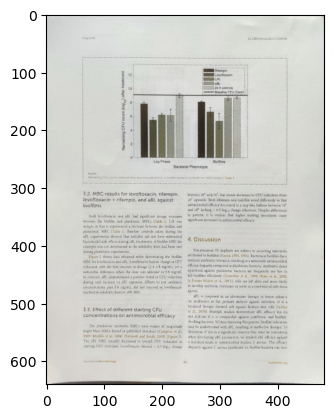

In [12]:
plt.imshow(imgWarp)

<BarContainer object of 256 artists>

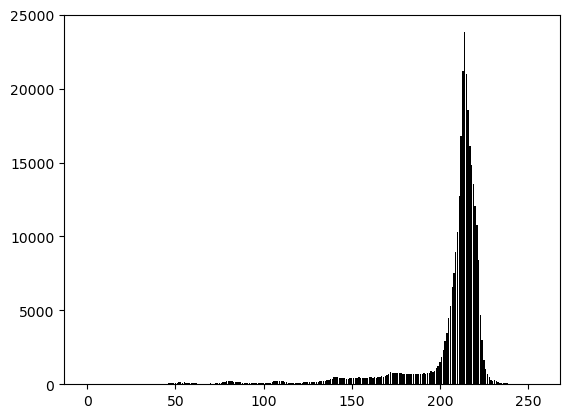

In [13]:
intensity_hist1 = cv2.calcHist([imgWarp], [0], None, [256], [0, 255])
intensity_hist1 = np.reshape(intensity_hist1,(intensity_hist1.shape[0]))
plt.bar(range(256),intensity_hist1,color='black')

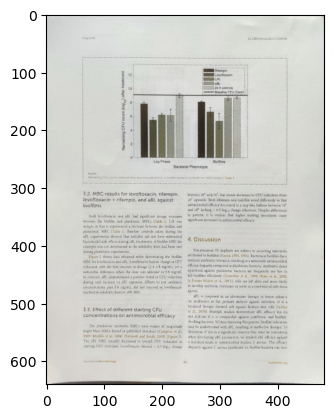

In [14]:
newImage = imgWarp.copy()
plt.imshow(newImage)

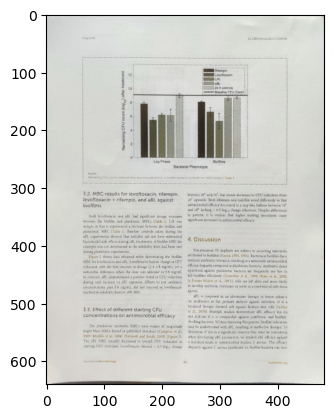

In [16]:
newImage2 = newImage.copy()
plt.imshow(newImage2)

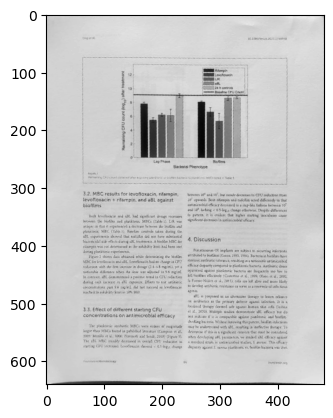

In [17]:
gray = cv2.cvtColor(newImage2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

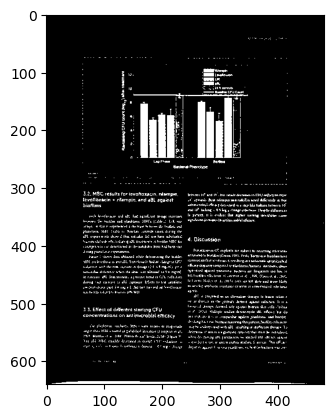

In [18]:
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(thresh,cmap='gray')

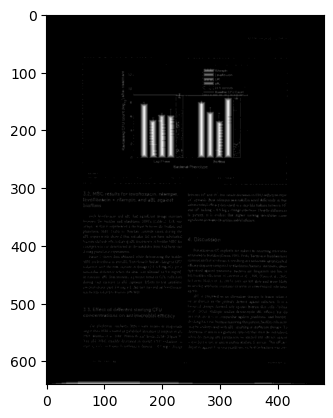

In [20]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L1, 5)
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist * 255).astype("uint8")
plt.imshow(dist,cmap='gray')

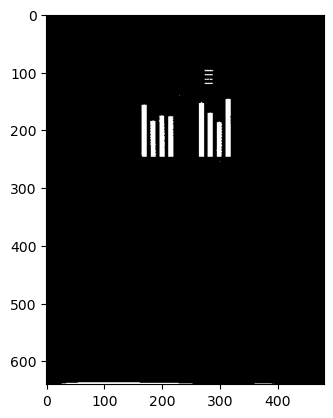

In [21]:
dist = cv2.threshold(dist, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(dist,cmap='gray')

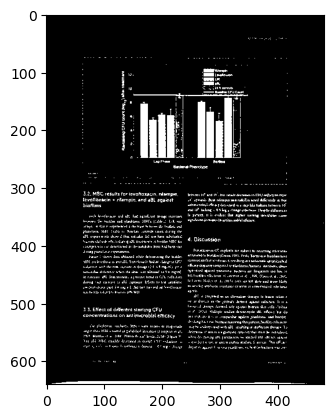

In [22]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
plt.imshow(opening,cmap='gray')

In [24]:
cnts = cv2.findContours(opening.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
chars = []
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if w >= 2 and h >= 2:
        chars.append(c)

In [25]:
chars = np.vstack([chars[i] for i in range(0, len(chars))])
chars

array([[[ 55, 635]],

       [[ 54, 636]],

       [[ 35, 636]],

       ...,

       [[270,   1]],

       [[271,   0]],

       [[386,   0]]], dtype=int32)

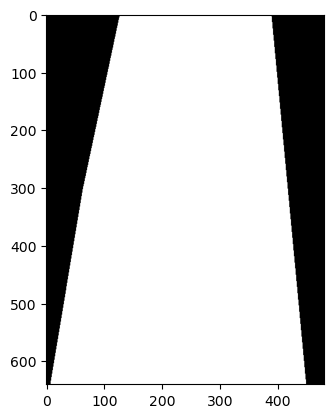

In [26]:
chars = np.vstack([chars[i] for i in range(0, len(chars))])
hull = cv2.convexHull(chars)
mask = np.zeros(newImage2.shape[:2], dtype="uint8")
cv2.drawContours(mask, [hull], -1, 255, -1)
mask = cv2.dilate(mask, None, iterations=2)
plt.imshow(mask,cmap='gray')

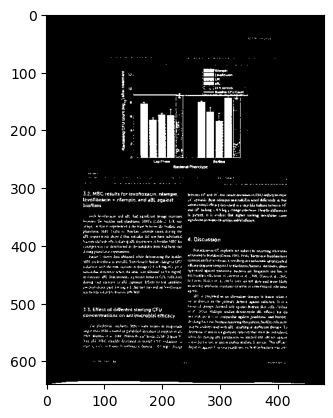

In [27]:
final = cv2.bitwise_and(opening, opening, mask=mask)
plt.imshow(final,cmap='gray')